<a href="https://colab.research.google.com/github/Zenith1618/LLM/blob/main/French_to_English_Translator_using_Seq2Seq_Bahdanau_Attention_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import random
import time

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

plt.switch_backend('agg')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Setting the seeding value

In [11]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

# Loading the dataset

The download link for the dataset is: https://download.pytorch.org/tutorial/data.zip

The file is a tab separated list of translation pair

Mapping words to index

In [22]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name    #Represents the name of the language.
    self.word2index = {}  #A dictionary mapping words to their respective indices.
    self.word2count = {}  #A dictionary to count occurrences of words.
    self.index2word = {0: "SOS", 1: "EOS"}  # A dictionary mapping indices to their respective words.
    self.n_words = 2  #An integer to keep track of the total number of unique words


  #Splits the input sentence into words and calls the addWord method for each word in the sentence.
  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  """
  Adds a word to the language's dictionaries if it's not already present.

  If the word doesn't exist (word not in self.word2index), it adds the word to word2index, assigns it a unique index (self.n_words),
  initializes its count to 1 in word2count, maps the index to the word in index2word, and increments n_words.

  If the word already exists in word2index, it increments the count for that word in word2count.
  """
  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count = 1
      self.index2word[self.n_words] = word
      self.n_words +=1
    else:
      self.word2count+=1

Language Pair Data Reading and Preprocessing

In [13]:
# Turn a Unicode string to plain ASCII, thanks to- https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)   #to add a space before punctuation marks
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)  # Replaces any character that is not a letter or specific punctuation marks (such as ! and ?) with a space.
    return s.strip()

In [14]:
def readLangs(lang1, lang2, reverse=False):
  print("Reading lines.......")

  # Read the file and split into lines
  lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

  # split the lines into pair and normalize them
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

  # Reverse Pair, and make language instances
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [15]:
MAX_LENGTH = 10   # maximum allowable length for sentences.

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

"""
This function takes a pair p as input, where p[0] represents one sentence in a pair and p[1] represents another sentence and checks
if the length of both sentences (split by spaces) is less than MAX_LENGTH and if the second sentence (p[1]) starts with any of the
prefixes defined in eng_prefixes.
It returns True if both conditions are met for the pair, indicating that it passes the filter.
"""
# Trying to get some specific type of sentences
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [16]:
def prepareData(lang1, lang2, reverse=False):

  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print("Read %s sentence pair" %len(pairs))

  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pair" % len(pairs))

  print("Counting words....")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

  print("Counted Words: ")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines.......
Read 135842 sentence pair
Trimmed to 11445 sentence pair
Counting words....
Counted Words: 
fra 4601
eng 2991
['nous craignons de manquer notre train', 'we re afraid we ll miss our train']


Since, we have passed reverse=True, our input is French and ouput is English

# Seq2Seq Attention

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.
</br>
</br>
![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

## Encoder Block Workflow

First, we'll build the encoder. We only use a single layer GRU. The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence.
</br>
</br>


![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)

In [17]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    # initializing embedding layer to convert input index into dense vectors
    self.embedding = nn.Embedding(input_size, hidden_size)

    # GRU Layer
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):

    embedded = self.dropout(self.embedding(input))
    # Pass the embedded vectors through the GRU layer
    # 'output' contains the GRU outputs for each time step in the sequence
    # 'hidden' is the final hidden state of the GRU after processing the sequence
    output, hidden = self.gru(embedded)
    return output, hidden


## Decoder Block

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the **Context vector** as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.


![decoder](https://pytorch.org/tutorials/_images/decoder-network.png)

In [18]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)


  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):

    batch_size = encoder_outputs.size(0)

    # initially decoder hidden state is encoder's final hidden states
    decoder_input = torch.empty(batch_size, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []

    for i in range(MAX_LENGTH):
      decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        # Teacher forcing: Feed the target as the next input
        decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
      else:
        # Without teacher forcing: use its own predictions as the next input
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input


      # Concatenate decoder outputs along the sequence length and apply log softmax to compute token probabilities
      decoder_outputs = torch.cat(decoder_outputs, dim =1)
      #dim=1 indicates concatenation along the sequence length (time steps). It's stacking these tensors horizontally.
      decoder_outputs = F.log_softmax(decoder_outputs, dim = -1)
      # log softmax should be computed along the last dimension of the tensor, which is typically the dimension representing the output vocabulary.

      return decoder_outputs, decoder_hidden, None
      # None is returned for consistency in the training loop

  def forward_step(self, input, hidden):
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output)

    return output, hidden


## Attention model building

The `BahdanauAttention` implements the Bahdanau Attention mechanism, which is a type of attention mechanism commonly used in sequence-to-sequence models, particularly in neural machine translation tasks.

This mechanism allows the model to focus on different parts of the input sequence while generating the output sequence.

In [19]:
class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    super(BahdanauAttention, self).__init__()

    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim= -1)
    context = torch.bmm(weights, keys)

    return context, weights

Let's break down the code and its purpose:

1. **Initialization (`__init__` method):**
   - `hidden_size`: This is the size of the hidden states of the sequences being processed by the attention mechanism.
   - Three linear layers are defined as part of the attention mechanism: `Wa`, `Ua`, and `Va`. These layers are used to learn different sets of parameters that are used to compute attention scores.

2. **Forward Pass (`forward` method):**
   - `query`: This represents the current decoder's hidden state. It's the state of the decoder at a specific time step.
   - `keys`: These are the encoder's hidden states, representing the entire input sequence.

   The goal of the Bahdanau Attention mechanism is to compute attention scores for each time step of the encoder and determine which parts of the input sequence are more relevant for generating the current output.

   - `self.Wa(query) + self.Ua(keys)`: This part calculates an intermediate value by summing the linear transformations of the decoder's hidden state and the encoder's hidden states. This helps the model to align the current decoder state with the encoder states.

   - `torch.tanh(...)`: The intermediate value is then passed through the hyperbolic tangent activation function to ensure that the values fall within a certain range.

   - `self.Va(...)`: The tanh-activated intermediate value is further passed through the third linear layer, which produces attention scores for each time step in the input sequence.

   - `scores.squeeze(2).unsqueeze(1)`: This reshapes the attention scores tensor to have a shape of `(batch_size, 1, sequence_length)`, where `sequence_length` is the length of the input sequence.

   - `F.softmax(...)`: The softmax function is applied to the attention scores along the sequence length dimension, resulting in attention weights that sum to 1 across the input sequence.

   - `torch.bmm(...)`: This performs a batch matrix multiplication between the attention weights and the encoder's hidden states. It computes the context vector, which is a weighted sum of the encoder's hidden states based on the attention weights.

   Finally, the `context` vector and the computed attention `weights` are returned.

## Attention Model Workflow

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [21]:
"""This decoder takes the encoder outputs and hidden states as input, generates a sequence by predicting tokens iteratively, and utilizes an attention mechanism to focus
on different parts of the input sequence during decoding."""

class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p = 0.1):
    super(AttnDecoderRNN, self).__init__()

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.attention = BahdanauAttention(hidden_size)
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    for i in range(MAX_LENGTH):
      decoder_output, decoder_hidden, attn_weights = self.forward_step(
          decoder_input, decoder_hidden, encoder_outputs
      )
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
          # Teacher forcing: Feed the target as the next input
          decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
      else:
          # Without teacher forcing: use its own predictions as the next input
          _, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    decoder_outputs = torch.cat(decoder_outputs, dim = 1)
    decoder_outputs = F.log_softmax(decoder_outputs, dim = -1)
    attentions = torch.cat(attentions, dim = 1)

    return decoder_outputs, decoder_hidden, attentions

  def forward_step(self, input, hidden, encoder_outputs):
    embedded =  self.dropout(self.embedding(input))     #Embeds the input

    query = hidden.permute(1, 0, 2)
    context, attn_weights = self.attention(query, encoder_outputs)      #Calculates the query, context, and attention weights using the attention mechanism
    input_gru = torch.cat((embedded, context), dim=2)   #Concatenates the embedded input and context vector

    output, hidden = self.gru(input_gru, hidden)    #Passes the concatenated input to the GRU
    output = self.out(output)       #Projects the GRU output to the output size

    return output, hidden, attn_weights


# Preparing data using TensorDataset to fit the Model

In [23]:
#eturns a list of indexes corresponding to the words in the sentence using the word2index mapping
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]
    # Splits the sentence into words and returns a list of indexes corresponding to the words in the sentence using the word2index mapping within the language object.

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)   #Calls indexesFromSentence to get the indexes for each word in the sentence.

    indexes.append(EOS_token)   #Appends an EOS_token (end of sentence) to mark the end of the sentence.

    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)   #Converts the list of indexes into a PyTorch tensor, reshaping it to have a shape of (1, sequence_length).

def tensorsFromPair(pair):  #converts each sentence into tensors
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#define the func above to create input and target tensors for the entire dataset of language pairs.
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    # arrays to store indexes of input and target sentences for the entire dataset.
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)   # Append EOS to mark the end of sentence
        tgt_ids.append(EOS_token)
        #Pads the arrays input_ids and target_ids with indexes, ensuring they match the maximum sequence length (MAX_LENGTH).
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Making tensordataset and dataloader from the above data with batching it
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

# Training


## Model Training

In [24]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [25]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [27]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Model Evaluation

In [28]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    #  generating translations

    with torch.no_grad():       # To switch off training
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)   #Selects the top predicted token (topi) for each step.
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])    #Converts the predicted token index to its corresponding word using the output_lang.index2word mapping.
    return decoded_words, decoder_attn

In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])     #Input Sentence
        print('=', pair[1])     #Target Sentence
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence) # Predicted Sentence
        print('')

## Training the Model

Reading lines.......
Read 135842 sentence pair
Trimmed to 11445 sentence pair
Counting words....
Counted Words: 
fra 4601
eng 2991
0m 38s (- 1m 55s) (5 25%) 1.5304
1m 19s (- 1m 19s) (10 50%) 0.6775
1m 58s (- 0m 39s) (15 75%) 0.3526
2m 37s (- 0m 0s) (20 100%) 0.1949


<Figure size 640x480 with 0 Axes>

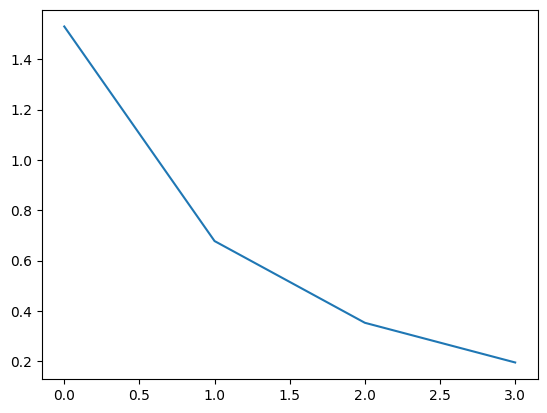

In [30]:
hidden_size = 128
batch_size = 32
epochs = 20

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

%matplotlib inline
train(train_dataloader, encoder, decoder, epochs, print_every=5, plot_every=5)

## Evaluation

In [31]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis myope
= i m nearsighted
< i m nearsighted <EOS>

> ils sont vieux
= they re old
< they re old enough <EOS>

> nous sommes toutes differentes
= we re all different
< we re all different <EOS>

> vous etes sur la liste
= you re on the list
< you re on the list man <EOS>

> je saigne gravement
= i m bleeding badly
< i m bleeding badly i can <EOS>

> il n est pas parfait
= he isn t perfect
< he s not perfect <EOS>

> tu es egoiste
= you re selfish
< you re selfish <EOS>

> aujourd hui elle va beaucoup mieux qu hier
= she s much better today than yesterday
< she s feeling much better today <EOS>

> ils courent dans le parc
= they are running in the park
< they are running in the park <EOS>

> je ne suis pas normal
= i m not normal
< i m not normal <EOS>



# Visualisation of how Attention mechanism Works

In [32]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [33]:
import warnings
warnings.filterwarnings("ignore")

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


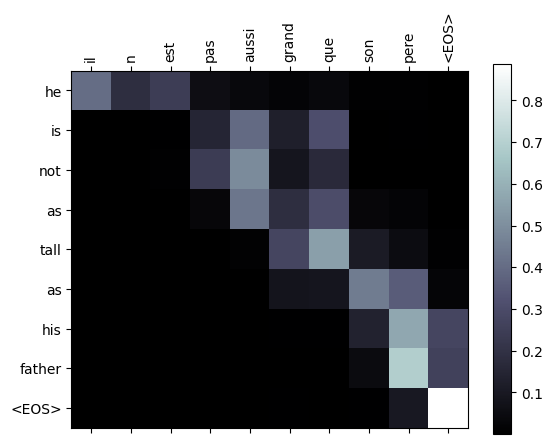

In [34]:
%matplotlib inline
evaluateAndShowAttention('il n est pas aussi grand que son pere')

input = je suis reellement fiere de vous
output = i m really proud of you guys <EOS>


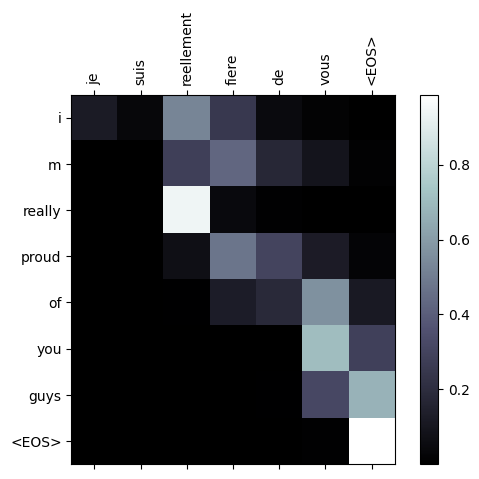

In [36]:
%matplotlib inline
evaluateAndShowAttention('je suis reellement fiere de vous')

input = je vais chez le dentiste demain
output = i am going to see the dentist tomorrow <EOS>


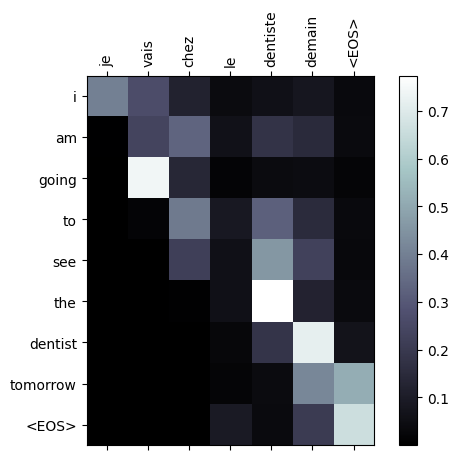

In [46]:
%matplotlib inline
evaluateAndShowAttention("je vais chez le dentiste demain")

input = j ai peur qu il ne soit pas la avant heures
output = i m afraid he will be not the entrance <EOS>


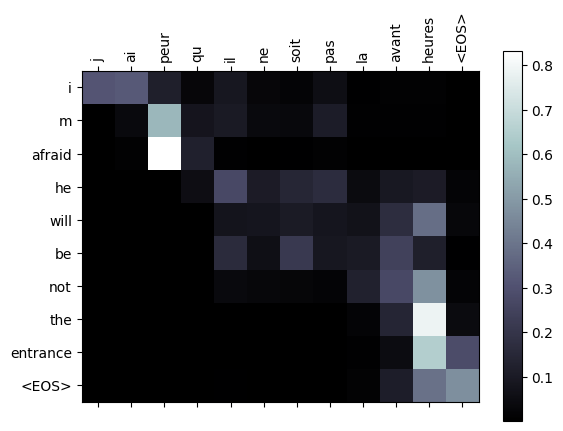

In [56]:
%matplotlib inline
evaluateAndShowAttention("j ai peur qu il ne soit pas la avant heures")